In [61]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [62]:
# Define the data path where datasets are stored
datapath = "data/"

# Define the drag coefficient
dt = 60*60*24

H = 3114
rho = 1025
Cd = 0.003

# Define the filenames for the datasets 
A4_file = "A4/A4_lofoten_h_50km_timeseries.nc" 
L800_file = "lofoten800/lofoten800_lofoten_h_50km_timeseries.nc" 

# Load the datasets using xarray
ts_A4 = xr.open_dataset(datapath + A4_file)
ts_L800 = xr.open_dataset(datapath + L800_file).sel(ocean_time=slice("01.01.1997", None))

# Adjusting surface stress
ts_A4["taucirc_area"] = ts_A4.taucirc_area/(H*rho)

ts_L800["taucirc_area"] = ts_L800.taucirc_area/(H*rho)

# Combining the two vorticity terms
ts_L800["zflux_area"] = ts_L800.zbarflux_area + ts_L800.znodflux_area


# Interpolating missing values TODO : fill in data gaps
ts_L800["ucirc_area"] = ts_L800["ucirc_area"].interpolate_na(dim="ocean_time", method="linear")
#ts_L800["ub2circ"] = ts_L800["ub2circ"].interpolate_na(dim="ocean_time", method="linear")

sns.set_theme("notebook")

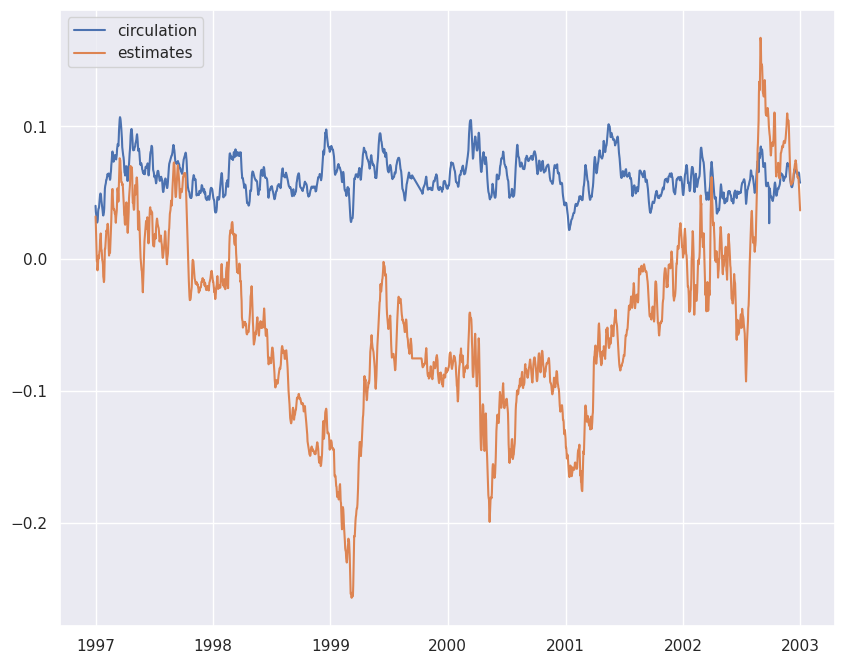

In [63]:
L_L800 = ts_L800.L_area
C_L800 = ts_L800.ucirc_area/L_L800
C0_L800 = C_L800.isel(ocean_time=0)



dCest_L800 = (( 
    + ts_L800.taucirc_area 
    + ts_L800.zflux_area 
    - ts_L800.fflux_area
    - Cd*ts_L800.ub2circ_area/H
    )/L_L800)

dC_L800 = C_L800.differentiate("ocean_time", datetime_unit = "s")

Cest_L800 = (dCest_L800*dt).cumsum("ocean_time")+C0_L800


fig, ax = plt.subplots(figsize=(10,8))

t = ts_L800.ocean_time
ax.plot(t, C_L800, label="circulation")
ax.plot(t, Cest_L800, label="estimates")

ax.legend()

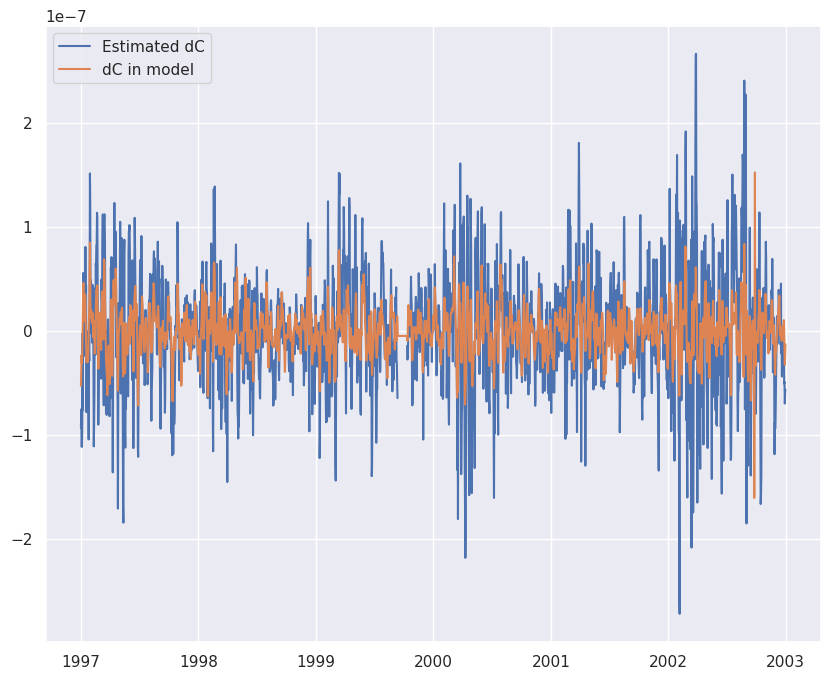

In [64]:
fig, ax = plt.subplots(figsize=(10,8))

t = ts_L800.ocean_time
ax.plot(t, dCest_L800, label="Estimated dC")
ax.plot(t, dC_L800, label="dC in model")

ax.legend()

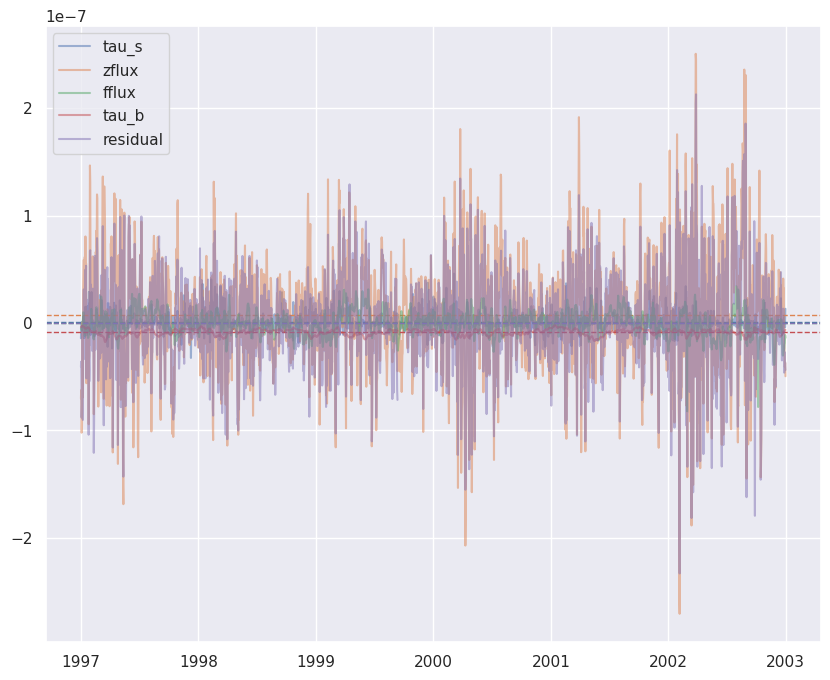

In [78]:
fig, ax = plt.subplots(figsize=(10,8))

dt_components = dict(
    tau_s=ts_L800.taucirc_area/L_L800, 
    zflux=+ ts_L800.zflux_area/L_L800, 
    fflux=- ts_L800.fflux_area/L_L800,
    tau_b=-Cd*ts_L800.ub2circ_area/L_L800/H,
    residual = dCest_L800-dC_L800
    
)



for label, dt in dt_components.items():
        # Plot the time series
    line, = ax.plot(t, dt, alpha=0.5, label=label)
    
    # Calculate and plot the time mean
    time_mean = dt.mean()
    ax.axhline(time_mean, color=line.get_color(), linestyle='--', linewidth=1)



ax.legend()
#ax.set_ylim(-1e-8, 1e-8)

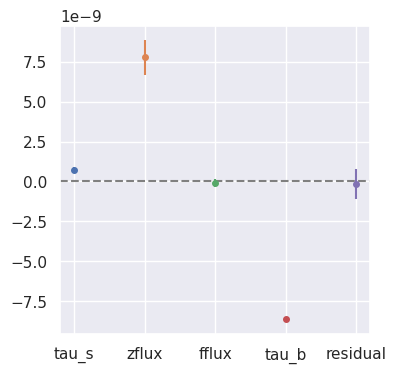

In [77]:
fig, ax = plt.subplots(figsize=(4,4))

i = 0
pos = []
labels = []
for label, dt in dt_components.items():
    dt_mean = dt.mean()
    dt_std = dt.std()
    conf = dt_std/np.sqrt(len(dt))

    ax.errorbar(i, dt_mean, yerr=conf, marker='o', markersize=4,label=label)
    pos.append(i)
    labels.append(label)
    i += 1

ax.axhline(0, color="gray", ls="--")
ax.set_xticks(pos, labels)